# 3. Building and evaluating different models

### How to do this:
- Only use training data set

Models to build:
- a dummy model: mean of y
- a baseline model: using only gender
- "full" models (including all predictors):
    - a simple linear regression
    - a non-parametric linear regression KNN
    - a simple decision tree
    - a random forrest regressor

Questions: shouldn't the dummy and basline models be the same model type as the chosen model? and then just including fewer predictors? 

All? or only the full models should be trained using CV and should be heavily regularized (_standardize_ first?). 
All models should be compared using the same error metric: mean squarred error 

choosing the best model, validate it, and then test it:
- investigate interpretability, feature importance, etc. 


In [28]:
# important relevant packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error # MSE?? rmse? 
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge

## random forrest og feature importance 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
import pickle as pkl




In [2]:
# load dependent variable
train = pd.read_csv('/work/datascience_exam/data/train.csv', index_col = 0)
y_train = train['Age of death']

In [5]:
# load data which has been embedded, clustered and dimensionality reduced using PCA
# using absolute path
#X_train_w_pca_vecs = np.load('/work/datascience_exam/data/oc_pca_train.npy', allow_pickle=True)
#X_train_w_pca_vecs[4,0:9]
X_train = pd.read_csv('/work/datascience_exam/data/X_train_occupation.csv', index_col = 0)

In [ ]:

X_train_gender = X_train_w_pca_vecs[:,0]
X_train_predictors = X_train_w_pca_vecs[:,3:]

X_train_predictors = np.hstack((X_train_gender.reshape(-1,1), X_train_predictors))



In [31]:
X_train_predictors[4,0:4]
#X_train_predictors.shape # 51 - 3 = 48

array([1, 1888, 0, 0.08846393972635269], dtype=object)

In [26]:
range(0,49)

range(0, 49)

In [ ]:
# change to pd dataframe

# Create list of column names with the format "colN" (from 1 to N)
#col_names = ['occupation' + str(i) for i in np.arange(X_train_predictors.shape[1]) + 1]
colnames_second = ['occupation' + str(i) for i in range(1,49)]


colnames_first = ['gender', 'birth_year', 'occupation_cluster']
colnames = colnames_first + colnames_second
colnames

In [35]:
# Declare pandas.DataFrame object

X_train = pd.DataFrame(data=X_train_predictors, columns=colnames)

In [36]:
X_train.head()

,gender,birth_year,occupation_cluster,occupation1,occupation2,occupation3,occupation4,occupation5,occupation6,occupation7,...,occupation39,occupation40,occupation41,occupation42,occupation43,occupation44,occupation45,occupation46,occupation47,occupation48
0,1,1802,5,-0.126581,-0.030999,0.020962,0.036347,0.446435,0.661136,-0.107335,...,-0.002635,0.002376,-0.002519,0.000743,0.002733,-0.001413,-0.001296,-0.003087,-0.002167,-0.002874
1,2,1884,2,0.634917,-0.059081,-0.079842,-0.018078,-0.042558,0.008224,0.00233,...,0.000065,-0.000137,-0.000086,-0.00002,0.000202,-0.00007,-0.000196,0.000246,0.000274,0.000192
2,1,1896,1,-0.439052,-0.390762,-0.207293,-0.003735,-0.062288,-0.011805,-0.012362,...,-0.000271,0.000968,0.000704,0.000251,0.000886,0.001017,-0.000067,0.000192,-0.000629,0.000217
3,1,1668,2,0.634916,-0.059099,-0.079964,-0.018206,-0.042371,0.008002,0.002234,...,-0.000157,-0.000266,-0.000387,-0.000069,0.000136,0.000148,0.000249,0.000143,0.000114,0.000093
4,1,1888,0,0.088464,-0.012277,0.255175,-0.004892,0.298965,-0.388414,-0.448571,...,0.005604,0.010579,0.004133,0.008129,-0.002182,-0.011388,0.006734,0.000842,-0.000157,-0.004653


## Standardizing embedded features - is that what we want to do?

In [ ]:
# standardize embedded data
scaler = StandardScaler()

X_train_scaled.loc[:,'occupation1':] = scaler.fit_transform(X_train.iloc[:,'occupation1':])

In [ ]:
# standardize embedded data
scaler = StandardScaler()
#X_train_pred_scaled = scaler.fit_transform(X_train_predictors[:,3:])

# pd version
#>>> dfTest[['A', 'B']] = scaler.fit_transform(dfTest[['A', 'B']])

X_train.iloc[:,3:51] = scaler.fit_transform(X_train.iloc[:,3:51])
X_train

In [ ]:
#_train_predictors_scaled = np.hstack((non_scaled_cols, X_train_pred_scaled))

## Building models

I want to build the following models:

- Model 1: A 'dummy' model with only the mean of y as feature
- Model 2: A 'baseline' model with only one feature (here, 'gender')
- Model 3: The full model which includes all predictors. 

Model 1 and 2 will be modelled as a linear regression. 

Model 3 will be modelled as a linear regression, KNN-regression and a random forrest.

In [35]:
performances = []

In [ ]:
#y_train.shape
#X_train_predictors.shape

In [13]:
### Dummy model  -  mean of y

#mean_value = y_train.mean()
#model_name = 'dummy'
#performance = np.sqrt(mean_squared_error(y_train, [mean_value]*y_train.shape[0]))
#r2 = r2_score(y_train, [mean_value]*y_train.shape[0])
#performances.append({'model': model_name,
#                     'split': 'train',
#                     'rmse': performance.round(4),
#                     'r2': r2.round(4)})



In [36]:
### Dummy model - PD version

mean_value = y_train.mean()
model_name = 'dummy'
performance = np.sqrt(mean_squared_error(y_train, [mean_value]*len(y_train)))
r2 = r2_score(y_train, [mean_value]*len(y_train))
performances.append({'model': model_name,
                     'split': 'train',
                     'rmse': performance.round(4),
                     'r2': r2.round(4)})

In [ ]:
### Baseline model - only predictor is gender - linear regression

#gender = X_train_predictors[:,0].reshape(-1,1)
#gender = gender.reshape(-1,1)
#reg = LinearRegression().fit(gender, y_train)

#preds =  reg.predict(gender)
#r2 = r2_score(y_train, preds)
#performance = np.sqrt(mean_squared_error(y_train, preds))
#performances.append({'model': 'linear-gender',
#                         'rmse': performance.round(4),
#                         'r2': r2.round(4)})


In [37]:
### Baseline model - only predictor is gender - linear regression - PD version

gender = X_train.loc[:, ['gender']]
#gender = gender.reshape(-1,1)
reg = LinearRegression().fit(gender, y_train)

preds =  reg.predict(gender)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': 'linear-gender',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [ ]:
### full linear model 
# cv? - this is not working out 
# regularization? 

#reg = LinearRegression().fit(X_train, y_train)

#preds =  reg.predict(X_train_predictors_scaled)
#r2 = r2_score(y_train, preds)
#performance = np.sqrt(mean_squared_error(y_train, preds))
#performances.append({'model': 'linear-full-scaled',
#                         'rmse': performance.round(4),
#                         'r2': r2.round(4)})


In [42]:
k = 20
neigh = KNeighborsRegressor(n_neighbors=k)
neigh.fit(gender, y_train)
#pkl.dump(neigh, file=open(f'example-models/knn-allpreds-{k}.pkl', 'wb')) # save the model

preds = neigh.predict(gender)

r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': f'knn-gender-{k}',
                        'split': 'train',
                        'rmse': performance.round(4),
                        'r2': r2.round(4)})

In [38]:
### full linear model --- PANDAS VERSION
# cv? - this is not working out 
# regularization? 

reg = LinearRegression().fit(X_train, y_train)

preds =  reg.predict(X_train)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': 'linear-full',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [ ]:
k = 20
neigh = KNeighborsRegressor(n_neighbors=k)
neigh.fit(X_train, y_train)
#pkl.dump(neigh, file=open(f'example-models/knn-allpreds-{k}.pkl', 'wb')) # save the model

preds = neigh.predict(X_train_predictors)

r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': f'knn-allpreds-{k}',
                        'split': 'train',
                        'rmse': performance.round(4),
                        'r2': r2.round(4)})

In [43]:
performances

[{'model': 'dummy', 'split': 'train', 'rmse': 15.9491, 'r2': 0.0},
 {'model': 'linear-gender', 'rmse': 15.9302, 'r2': 0.0024},
 {'model': 'linear-full', 'rmse': 15.4966, 'r2': 0.0559},
 {'model': 'knn-gender-20', 'split': 'train', 'rmse': 16.4257, 'r2': -0.0607}]

In [ ]:
# here put full random forrest model 


## trying to implement regularization
We want to do that at a better model than the linear regression

In [25]:
def evaluate(model, X, y, nsplit, model_name, constant_value=None):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): string id of the model
        constant_value (int or None): relevant if the model predicts a constant
    '''
    if constant_value is not None:
        preds = np.array([constant_value] * y.shape[0])
    else:
        preds = model.predict(X)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [21]:
models = {} # storing fitted models in the next chunk
models['linear-0.0'] = reg

In [26]:
for alpha in [0.01, 0.1, 0.2, 0.5, 1.0, 20.0, 10.0, 100.0, 1000.0]:
    for est in [Lasso, Ridge]:
        if est == Lasso:
            id = 'lasso'
        else:
            id = 'ridge'
        reg = est(alpha=alpha).fit(X_train, y_train)
        models[f'{id}-{alpha}'] = reg
        for x,y,nsplit in zip([X_train],
                            [y_train],
                            ['train']):
            evaluate(model=reg, 
                    X=x, y=y, 
                    nsplit=nsplit, 
                    model_name=f'linear-{id}-alpha-{alpha}')

/tmp/ipykernel_13432/1827935479.py:2: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False),


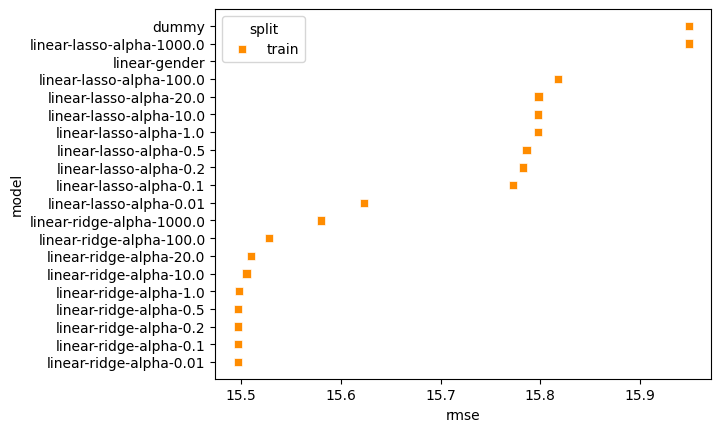

In [29]:
perf_df = pd.DataFrame(performances)
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

In [30]:
perf_df[perf_df['split']=='train'].sort_values(by='rmse', ascending=True)

,model,split,rmse,r2
4,linear-ridge-alpha-0.01,train,15.4966,0.0559
6,linear-ridge-alpha-0.1,train,15.4967,0.0559
8,linear-ridge-alpha-0.2,train,15.4968,0.0559
10,linear-ridge-alpha-0.5,train,15.4971,0.0559
12,linear-ridge-alpha-1.0,train,15.4978,0.0558
16,linear-ridge-alpha-10.0,train,15.5052,0.0549
14,linear-ridge-alpha-20.0,train,15.5098,0.0543
18,linear-ridge-alpha-100.0,train,15.5282,0.0521
20,linear-ridge-alpha-1000.0,train,15.5801,0.0457
3,linear-lasso-alpha-0.01,train,15.6232,0.0405


# Code below with attempt of CV needs to be fixed
Models need to be actually fitted. 

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

# Define the cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=1)  # 5-fold cross-validation

# Perform cross-validation with RMSE as the scoring metric
scores = cross_val_score(model, X_train_predictors_scaled, y_train, cv=kf, scoring='neg_root_mean_squared_error')

# Calculate the average RMSE and standard deviation
rmse_scores = -scores  # Convert negative RMSE scores to positive
#print(f"Mean RMSE: {rmse_scores:.2f}") #, Standard Deviation of RMSE: {std_rmse:.2f}")



In [ ]:
model_fit = model.fit(X_train_predictors_scaled, y_train)

preds =  model_fit.predict(X_train_predictors_scaled)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': 'linear-full-scaled-cv',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [ ]:
performances

In [ ]:
### full model but using polynomial linear regression
from sklearn.preprocessing import PolynomialFeatures

X_train_copy = X_train_predictors_scaled.copy()

poly = PolynomialFeatures(2)

X_train_copy = poly.fit_transform(X_train_copy)
reg = LinearRegression().fit(X_train_copy, y_train)
preds = reg.predict(X_train_copy)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': 'poly-allpreds-3',
                    'split': 'train',
                    'rmse': performance.round(4),
                    'r2': r2.round(4)})
       

In [33]:
# full model but using KNN linear regression

for k in [3,5,10,20,30]:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train, y_train)
    #pkl.dump(neigh, file=open(f'example-models/knn-allpreds-{k}.pkl', 'wb')) # save the model

    preds = neigh.predict(X_train)

    r2 = r2_score(y_train, preds)
    performance = np.sqrt(mean_squared_error(y_train, preds))
    performances.append({'model': f'knn-allpreds-{k}',
                            'split': 'train',
                            'rmse': performance.round(4),
                            'r2': r2.round(4)})

In [ ]:
k = 100
neigh = KNeighborsRegressor(n_neighbors=k)
neigh.fit(X_train_predictors, y_train)
#pkl.dump(neigh, file=open(f'example-models/knn-allpreds-{k}.pkl', 'wb')) # save the model

preds = neigh.predict(X_train_predictors)

r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': f'knn-allpreds-{k}',
                        'split': 'train',
                        'rmse': performance.round(4),
                        'r2': r2.round(4)})

In [ ]:
performances


Need to actually read about the different parameters

In [ ]:
rfreg = RandomForestRegressor(random_state=42) # first, we instantiate the estimator


In [ ]:

param_grid = { 
    'n_estimators': [10, 20, 100, 200, 500],
    'max_depth' : [2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': [0.3, 0.6, 0.9], # can you guess what this is, without looking at the documentation?
    'ccp_alpha': [0.01, 0.1, 1.0]
}

In [ ]:
# cv
cv_rfr = RandomizedSearchCV(estimator=rfreg, # I am choosing RandomizedSearchCV for speed, but you can also go for GridSearchCV :)
                            param_distributions=param_grid,
                            scoring='neg_mean_squared_error', # this is "neg" because CV wants a metric to maximize
                            n_iter=20, # this should more likely be above 100, and in general the higher the better
                            cv=5)
cv_rfr.fit(X_train_predictors_scaled, y_train)

# 100 min - save model in variable as with pickle 

In [ ]:
cv_rfr.best_estimator_.get_params()

In [ ]:
random_forrest_model = cv_rfr.fit(X_train_predictors_scaled, y_train)

In [ ]:
pkl.dump(random_forrest_model, file=open(f'models/random_forrest.pkl', 'wb')) # save the model

In [ ]:
model = cv_rfr.best_estimator_

preds = model.predict(X_train_predictors_scaled)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': 'random_forrest',
                         'split': 'train',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [ ]:
perf_df = pd.DataFrame(performances)
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

In [ ]:
importances = cv_rfr.best_estimator_.feature_importances_
# the above computes the (normalized) total reduction of the criterion brought by that feature.

In [ ]:
sns.barplot(x=train.columns.tolist(), y=importances, color=sns.color_palette()[0])
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
#plt.gca().set_xticks(plt.gca().get_xticks()[::2])  # Show every 10th tick # [::10]


plt.show()

Make xgboost? why is it better? 
or a single decision tree before random forrest?